In [1]:
import numpy as np
import pandas as pd
import importlib
import simulate_data
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest
from econml.metalearners import SLearner, TLearner

importlib.reload(simulate_data)

<module 'simulate_data' from 'D:\\Delft\\Year 3\\Q4\\code\\research-project\\simulate_data.py'>

# Example Simulation
Balanced case with simple CATE

In [4]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n = 5000

sim = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n))

sim_y = sim["Y"]
sim_w = sim["W"]
sim_x = pd.DataFrame(sim["X"].tolist(), index = sim.index)
sim_x.columns = sim_x.columns.astype(str)
sim_x_s = sim_x.assign(W=pd.Series(sim_w).values)

sim_x_t_0 = pd.DataFrame(sim.query("W==0")["X"].tolist())
sim_x_t_0.columns = sim_x_t_0.columns.astype(str)
sim_x_t_1 = pd.DataFrame(sim.query("W==1")["X"].tolist())
sim_x_t_1.columns = sim_x_t_1.columns.astype(str)

print(sim_y[0])

sim_x_t_0

-4.826161600351657


,0,1,2,3,4
0,0.801671,0.561645,0.177042,1.476753,-0.718755
1,-1.015443,1.021717,0.205096,-1.199974,0.773406
2,1.167843,-0.772753,-0.452345,-1.193693,0.357974
3,-0.124800,1.121527,-0.499186,0.836919,-0.291449
4,1.541758,-0.794094,-0.520978,0.712413,0.240578
...,...,...,...,...,...
2500,0.113454,-0.719241,-0.827756,1.252905,0.117828
2501,0.367357,-0.716261,-1.502770,0.406836,-1.458211
2502,-0.211154,-1.261308,0.815969,0.764667,-0.255484
2503,0.655898,-1.226710,-0.142637,-0.185223,0.097332


## S-learner

In [5]:
# regr = RandomForestRegressor(n_estimators=30, min_samples_split=10)
regr = RandomForestRegressor()
# regr = LinearRegression()
regr.fit(sim_x_s, sim_y)

y_fitted = regr.predict(sim_x_s)
print(y_fitted[0])
mean_squared_error(sim_y, y_fitted)

-4.7104641629954855


0.08048730938133021

In [6]:
sim_test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, 1000))

sim_test_x = pd.DataFrame(sim_test["X"].tolist(), index=sim_test.index)
sim_test_x.columns = sim_test_x.columns.astype(str)

test_sim_x_0 = sim_test_x.assign(**{"W": 0})
test_sim_x_1 = sim_test_x.assign(**{"W": 1})
test_sim_y = np.append(sim_test["Y0"], sim_test["Y1"])

y_test_pred = regr.predict(pd.concat([test_sim_x_0, test_sim_x_1]))
mean_squared_error(test_sim_y, y_test_pred)


0.5616859839304142

In [7]:
def sensitivity(data, y, t):
        # line coefficient for the one variable linear regression
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    ## add (rows/size) as a normalizer.
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [8]:
s_learner_cate_train = (regr.predict(sim_x.assign(**{"W": 1})) -
                        regr.predict(sim_x.assign(**{"W": 0})))

s_learner_cate_test = sim_test_x.assign(
    cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
          regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
)

In [9]:
s_learner_cate_test

,0,1,2,3,4,cate
0,1.026356,-0.731522,1.515982,-0.988922,0.230782,19.890544
1,0.285331,-0.296272,-0.769337,0.594649,-1.418580,19.385760
2,0.045178,-0.580659,0.771618,-1.847037,1.184226,20.542422
3,0.138857,-0.365329,1.628362,-0.872321,-0.949742,19.983252
4,0.582227,-0.944540,0.707801,0.988743,-0.403035,20.451079
...,...,...,...,...,...,...
995,-1.198206,0.093975,1.776719,0.816837,-0.457588,19.793134
996,0.088904,-0.678396,-0.269286,1.456539,-0.298346,19.206652
997,-3.049984,-0.519140,-0.270971,0.315563,-0.033970,20.016015
998,-0.465157,-0.924017,1.036060,-0.849954,0.329425,19.639746


In [10]:
mean_squared_error(s_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.30185756173849404

# T-learner

In [11]:
regr0 = RandomForestRegressor()
regr1 = RandomForestRegressor()

regr0.fit(sim_x_t_0, sim.query("W==0")["Y"])
regr1.fit(sim_x_t_1, sim.query("W==1")["Y"])

t_learner_cate_train = regr1.predict(sim_x) - regr0.predict(sim_x)
t_learner_cate_test = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))

In [12]:
t_learner_cate_test

,0,1,2,3,4,cate
0,1.026356,-0.731522,1.515982,-0.988922,0.230782,19.893306
1,0.285331,-0.296272,-0.769337,0.594649,-1.418580,19.220942
2,0.045178,-0.580659,0.771618,-1.847037,1.184226,20.639085
3,0.138857,-0.365329,1.628362,-0.872321,-0.949742,20.156593
4,0.582227,-0.944540,0.707801,0.988743,-0.403035,20.443012
...,...,...,...,...,...,...
995,-1.198206,0.093975,1.776719,0.816837,-0.457588,19.963848
996,0.088904,-0.678396,-0.269286,1.456539,-0.298346,19.486399
997,-3.049984,-0.519140,-0.270971,0.315563,-0.033970,20.380013
998,-0.465157,-0.924017,1.036060,-0.849954,0.329425,19.596315


In [13]:
mean_squared_error(t_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.2932648751689857

In [16]:
cau_forest = CausalForest()
cau_forest.fit(sim_x, sim_w, sim_y)

ret = cau_forest.predict(sim_test_x)
ret

array([[20.09320387],
       [19.59305067],
       [20.1924082 ],
       [20.15112728],
       [20.06222199],
       [19.71857715],
       [20.31729773],
       [20.29800443],
       [19.98669887],
       [18.54624772],
       [20.19815096],
       [20.07768823],
       [19.76973362],
       [20.39446873],
       [19.84482997],
       [20.4112107 ],
       [19.87626267],
       [19.93225839],
       [20.79255233],
       [20.33767615],
       [20.08130169],
       [20.14383643],
       [19.58574113],
       [19.52713059],
       [19.78824982],
       [20.0952836 ],
       [19.38355335],
       [19.82674649],
       [19.99048044],
       [19.66966915],
       [19.78820032],
       [19.97082041],
       [20.11874478],
       [19.95877144],
       [19.78716966],
       [20.12153571],
       [20.11492805],
       [19.91339875],
       [20.24731544],
       [19.92028493],
       [19.78772176],
       [20.09854822],
       [19.92993092],
       [20.01054219],
       [19.9140071 ],
       [20

In [17]:
mean_squared_error(ret, sim_test.Y1 - sim_test.Y0)

0.06630805651806682

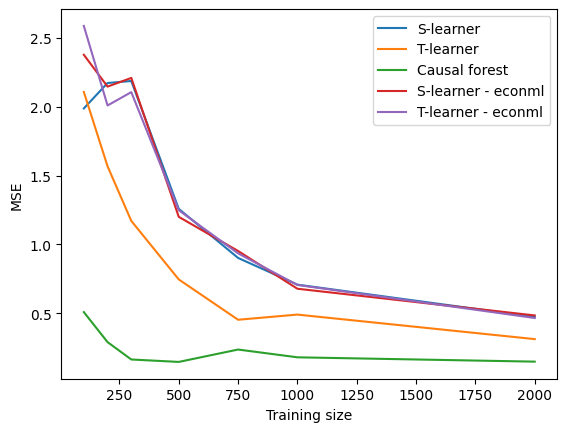

In [18]:
training_sizes = [100, 200, 300, 500, 750, 1000, 2000]
mse_s = []
mse_t = []
mse_forest = []
mse_econml_s = []
mse_econml_t = []
for size in training_sizes:
    # S-learner
    regr = RandomForestRegressor()
    regr.fit(sim_x_s.head(size), sim_y.head(size))
    s_learner_cate = sim_test_x.assign(
        cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
            regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
    )
    mse_s.append(mean_squared_error(s_learner_cate.cate, sim_test.Y1 - sim_test.Y0))
    # T-learner
    regr0 = RandomForestRegressor()
    regr1 = RandomForestRegressor()
    regr0.fit(sim_x_t_0.head(size), sim.query("W==0")["Y"].head(size))
    regr1.fit(sim_x_t_1.head(size), sim.query("W==1")["Y"].head(size))
    t_learner_cate = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))
    mse_t.append(mean_squared_error(t_learner_cate.cate, sim_test.Y1 - sim_test.Y0))
    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(sim_x.head(size), sim_w.head(size), sim_y.head(size))
    causal_forest_cate = cau_forest.predict(sim_test_x)
    mse_forest.append(mean_squared_error(causal_forest_cate, sim_test.Y1 - sim_test.Y0))
    econml_s = SLearner(overall_model=RandomForestRegressor())
    econml_s.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_s_cate = econml_s.effect(sim_test_x)
    mse_econml_s.append(mean_squared_error(econml_s_cate, sim_test.Y1 - sim_test.Y0))
    econml_t = TLearner(models=RandomForestRegressor())
    econml_t.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_t_cate = econml_t.effect(sim_test_x)
    mse_econml_t.append(mean_squared_error(econml_t_cate, sim_test.Y1 - sim_test.Y0))
plt.plot(training_sizes, mse_s, label="S-learner")
plt.plot(training_sizes, mse_t, label="T-learner")
plt.plot(training_sizes, mse_forest, label="Causal forest")
plt.plot(training_sizes, mse_econml_s, label="S-learner - econml")
plt.plot(training_sizes, mse_econml_t, label="T-learner - econml")
plt.ylabel("MSE")
plt.xlabel("Training size")
plt.legend()
plt.show()

# Testing setup

In [19]:
def run_test(d, mu_0, mu_1, e, n_train, n_test, reps):
    #               sim_x, sim_w, sim_y, sim_test_x, sim_test

    training_sizes = [100, 200, 300, 500, 750, 1000, 2000]
    mse_s_final = []
    mse_t_final = []
    mse_forest_final = []

    for size in training_sizes:
        mse_s = []
        mse_t = []
        mse_forest = []
        for i in range(reps):

            train = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
            test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))

            train_x = pd.DataFrame(train["X"].tolist(), index = train.index)
            train_x.columns = train_x.columns.astype(str)
            train_y = train["Y"]
            train_w = train["W"]

            train_x_s = train_x.assign(W=pd.Series(train_w).values)
            train_x_t_0 = pd.DataFrame(train.query("W==0")["X"].tolist())
            train_x_t_0.columns = train_x_t_0.columns.astype(str)
            train_x_t_1 = pd.DataFrame(train.query("W==1")["X"].tolist())
            train_x_t_1.columns = train_x_t_1.columns.astype(str)

            test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
            test_x.columns = test_x.columns.astype(str)

            true_test_cate = test.Y1 - test.Y0

            # S-learner
            regr = RandomForestRegressor()
            regr.fit(train_x_s.head(size), train_y.head(size))

            s_learner_cate = test_x.assign(
                cate=(regr.predict(test_x.assign(**{"W": 1})) - # predict under treatment
                    regr.predict(test_x.assign(**{"W": 0}))) # predict under control
            )
            mse_s.append(mean_squared_error(s_learner_cate.cate, true_test_cate))

            # T-learner
            regr0 = RandomForestRegressor()
            regr1 = RandomForestRegressor()
            regr0.fit(train_x_t_0.head(size), train.query("W==0")["Y"].head(size))
            regr1.fit(train_x_t_1.head(size), train.query("W==1")["Y"].head(size))

            t_learner_cate = test_x.assign(cate=regr1.predict(test_x) - regr0.predict(test_x))
            mse_t.append(mean_squared_error(t_learner_cate.cate, true_test_cate))

            # Causal forest
            cau_forest = CausalForest()
            cau_forest.fit(train_x.head(size), train_w.head(size), train_y.head(size))

            causal_forest_cate = cau_forest.predict(test_x)
            mse_forest.append(mean_squared_error(causal_forest_cate, true_test_cate))

        mse_s_final.append(np.mean(mse_s))
        mse_t_final.append(np.mean(mse_t))
        mse_forest_final.append(np.mean(mse_forest))


    plt.plot(training_sizes, mse_s_final, label="S-learner")
    plt.plot(training_sizes, mse_t_final, label="T-learner")
    plt.plot(training_sizes, mse_forest_final, label="Causal forest")
    plt.ylabel("MSE")
    plt.xlabel("Training size")
    plt.legend()
    plt.show()

# Case 1

Balanced, with simple cate

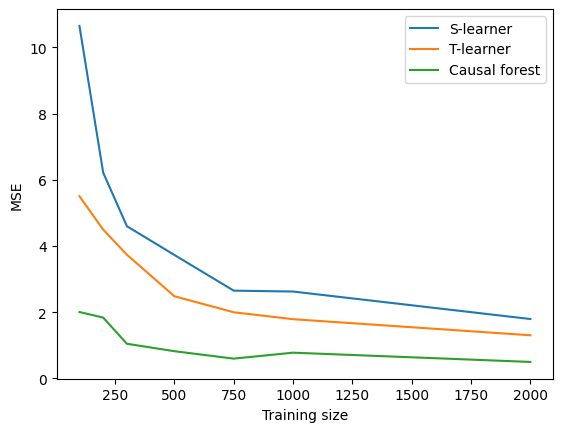

In [20]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n_train = 5000
n_test = 1000

run_test(d, mu_0, mu_1, e, n_train, n_test, 5)

# Case 2

Unbalanced, simple cate

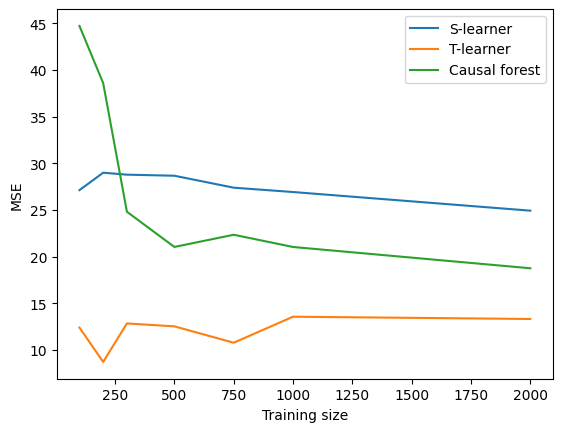

In [22]:
e = lambda x: 0.01
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) + 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 8 * (1 if x[1] > 0.1 else 0)
n_train = 5000
n_test = 1000

run_test(d, mu_0, mu_1, e, n_train, n_test, 5)

# Case 3

Balanced, complex linear cate, no confounding

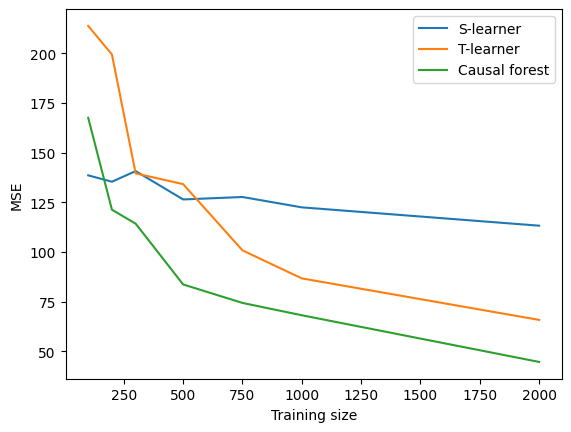

In [23]:
e = lambda x: 0.5
d = 5
weights_1 = np.random.uniform(1, 30, d)
weights_2 = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights_1)
mu_1 = lambda x: np.dot(x, weights_2)
n_train = 5000
n_test = 1000

run_test(d, mu_0, mu_1, e, n_train, n_test, 5)

# Case 4

Balanced, complex non-liner cate, no confounding

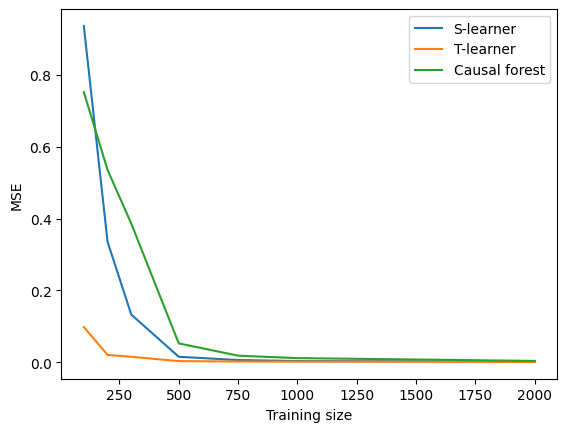

In [25]:
e = lambda x: 0.5
d = 5
fun = lambda x : 2.0 / (1 + np.exp(-12 * (x - 0.5)))
mu_0 = lambda x: 0.5 * fun(x[0]) * fun(x[1])
mu_1 = lambda x: -0.5 * fun(x[0]) * fun(x[1])
n_train = 5000
n_test = 1000

run_test(d, mu_0, mu_1, e, n_train, n_test, 5)

# Case 5

Balanced, no treatment effect

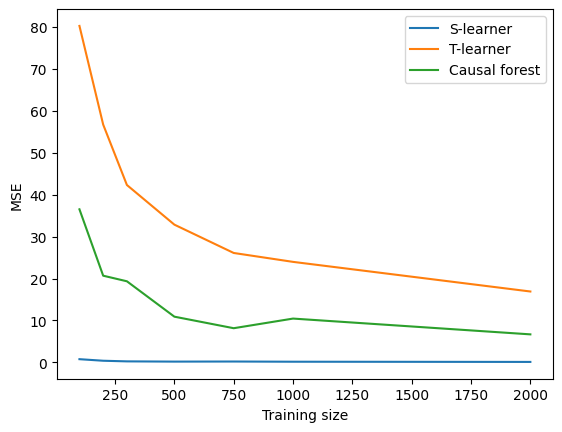

In [26]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights)
mu_1 = lambda x: mu_0(x)
n_train = 5000
n_test = 1000

run_test(d, mu_0, mu_1, e, n_train, n_test, 5)

# Case 6

Balanced, no treatment effect, piecewise function

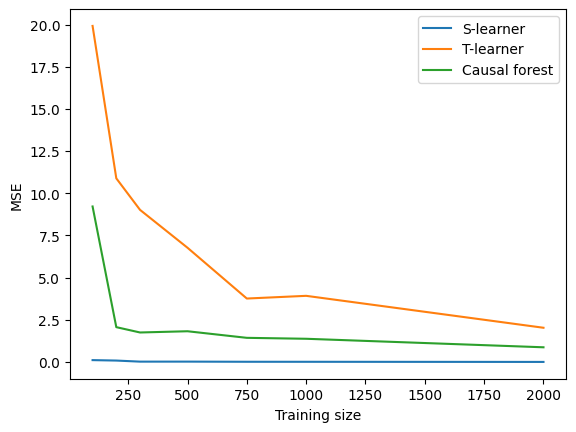

In [29]:
e = lambda x: 0.5
d = 8
weights_1 = np.concatenate((np.random.uniform(-15, 15, 2), [0,0,0,0,0,0]))
weights_2 = np.concatenate(([0,0], np.random.uniform(-15, 15, 2), [0,0,0,0]))
weights_3 = np.concatenate(([0,0,0,0], np.random.uniform(-15, 15, 2), [0,0]))
def mu_0(x):
    if x[7] < -0.4:
        return np.dot(x, weights_1)
    elif x[7] < 0.4:
        return np.dot(x, weights_2)
    else:
        return np.dot(x, weights_3)
mu_1 = lambda x: mu_0(x)
n_train = 5000
n_test = 1000

run_test(d, mu_0, mu_1, e, n_train, n_test, 5)